In [63]:
# Predict on test set

import dataset
import imp
import autoencoders
import numpy as np
import pandas as pd
import os
import pickle
import sklearn
import keras

imp.reload(dataset)

save_dir = 'cached/fma_small_mfcc_conv_m6000_fps1'
mfcc_save_path = os.path.join(save_dir, 'mfcc.npy')
tracks_save_path = os.path.join(save_dir, 'tracks')
params_save_path = os.path.join(save_dir, 'params')
net_save_path = os.path.join(save_dir, 'net')

try:
    dataset.load_fma(sample_size=2000, save_dir=save_dir, fps=1, num_segments=10)
except:
    print('Data already loaded')

x = np.load(mfcc_save_path)
tracks = pd.read_pickle(tracks_save_path)
with open(params_save_path, 'rb') as pf:
    sample_size, sr, fps, mfcc, num_segments, save_dir = pickle.load(pf)

# Normalize
x = x.reshape((x.shape[0], 1))
x = sklearn.preprocessing.normalize(x)
x = x.reshape((x.shape[0],))

# Shape for training
num_frames = int(x.shape[0] / (sample_size * num_segments * mfcc))
x = x.reshape(sample_size * num_segments, mfcc, num_frames, 1)

# Pad
scale = 2 ** 3
pad_frames = (int(num_frames / scale) + 1) * scale - num_frames
x_pad_frames = np.zeros((sample_size * num_segments, mfcc, pad_frames, 1))
x = np.concatenate((x, x_pad_frames), axis=2)
pad_mfcc = (int(mfcc / scale) + 1) * scale - mfcc
x_pad_mfcc = np.zeros((sample_size * num_segments, pad_mfcc, x.shape[2], 1))
x = np.concatenate((x, x_pad_mfcc), axis=1)

# Split
x_train, x_test = dataset.split_data(x)
print('Training shape', x_train.shape)
print('Test shape', x_test.shape)

track_index = tracks.index
training_size = int(x_train.shape[0]/num_segments)
test_size = int(x_test.shape[0]/num_segments)
tidx_train, tidx_test = track_index[:training_size], tracks.index[training_size:]
print('Training tracks shape', tidx_train.shape)
print('Test tracks shape', tidx_test.shape)

# Load trained ae
ae = keras.models.load_model(net_save_path)
ae.summary()

# Predict
y = encoder.predict(x_test)
print('Prediction shape', y.shape)

Data already loaded
Training shape (96000, 24, 32, 1)
Test shape (24000, 24, 32, 1)
Training tracks shape (4800,)
Test tracks shape (1200,)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 24, 32, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 32, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 16, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 16, 8)         1160      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 8, 8)           0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 6, 8, 4)           292       
__

In [64]:
# Extract encodings
y = y.reshape(test_size, num_segments, int(y.size / (test_size * num_segments)))
encodings = {}
for i, idx in enumerate(tidx_test):
    encodings[idx] = y[i, :, :]
for enc in encodings.values():
    encoding_shape = enc.shape
    break
print('Encoding shape', encoding_shape)

Encoding shape (20, 12)


In [65]:
# Separate a few genres

import pandas as pd
test_tracks = tracks.loc[tidx_test, :]
hiphop = test_tracks[test_tracks['track', 'genre_top'] == 'Hip-Hop']
folk = test_tracks[test_tracks['track', 'genre_top'] == 'Folk']
electronic = test_tracks[test_tracks['track', 'genre_top'] == 'Electronic']
instrumental = test_tracks[test_tracks['track', 'genre_top'] == 'Instrumental']
experimental = test_tracks[test_tracks['track', 'genre_top'] == 'Experimental']
international = test_tracks[test_tracks['track', 'genre_top'] == 'International']
rock = test_tracks[test_tracks['track', 'genre_top'] == 'Rock']

/home/rbiswas/.virtualenvs/deep-audioviz3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


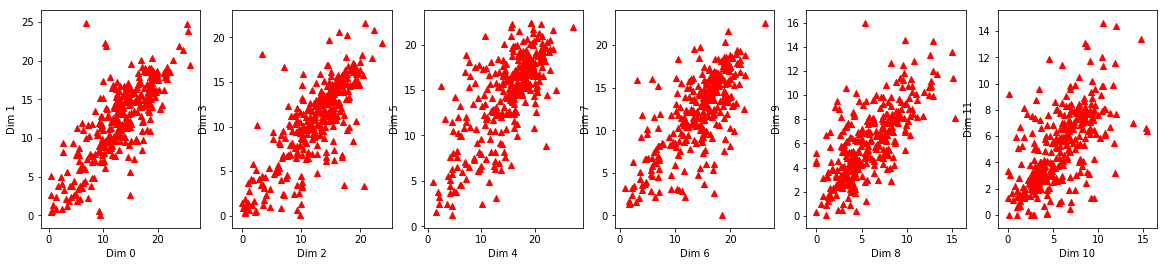

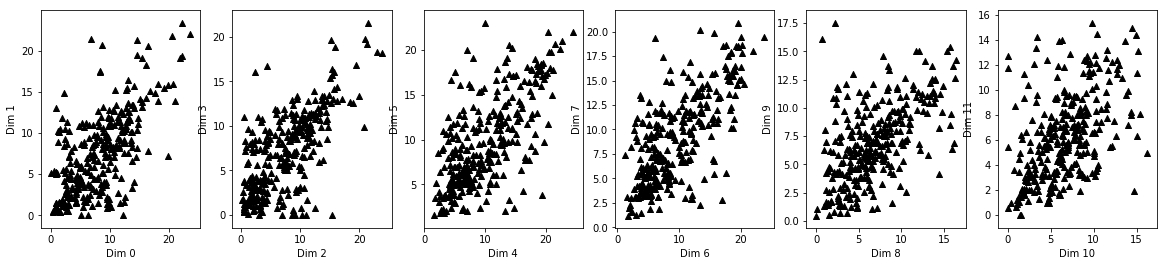

In [66]:
# Visualize 2 dimensions of the encodings for multiple segments in scatter plots

import matplotlib.pyplot as plt
import pylab
%matplotlib inline
pylab.rcParams['figure.figsize'] = (20, 4)

sample = np.arange(int(num_segments/10))
np.random.shuffle(sample)

for idx in folk.index:
    toplot = range(0,encoding_shape[1],2)
    for i, dim in enumerate(toplot):
        dim1 = dim
        dim2 = dim+1
        encoded = encodings[idx]
        x = np.transpose(encoded[sample, dim1])
        y = np.transpose(encoded[sample, dim2])
        plt.subplot(1,len(toplot), i+1)
        plt.xlabel('Dim {0}'.format(dim1))
        plt.ylabel('Dim {0}'.format(dim2))
        plt.scatter(x, y, marker='^', c='red')
plt.show()

for idx in hiphop.index:
    toplot = range(0,encoding_shape[1],2)
    for i, dim in enumerate(toplot):
        dim1 = dim
        dim2 = dim+1
        encoded = encodings[idx]
        x = np.transpose(encoded[sample, dim1])
        y = np.transpose(encoded[sample, dim2])
        plt.subplot(1,len(toplot), i+1)
        plt.xlabel('Dim {0}'.format(dim1))
        plt.ylabel('Dim {0}'.format(dim2))
        plt.scatter(x, y, marker='^', c='black')
plt.show()

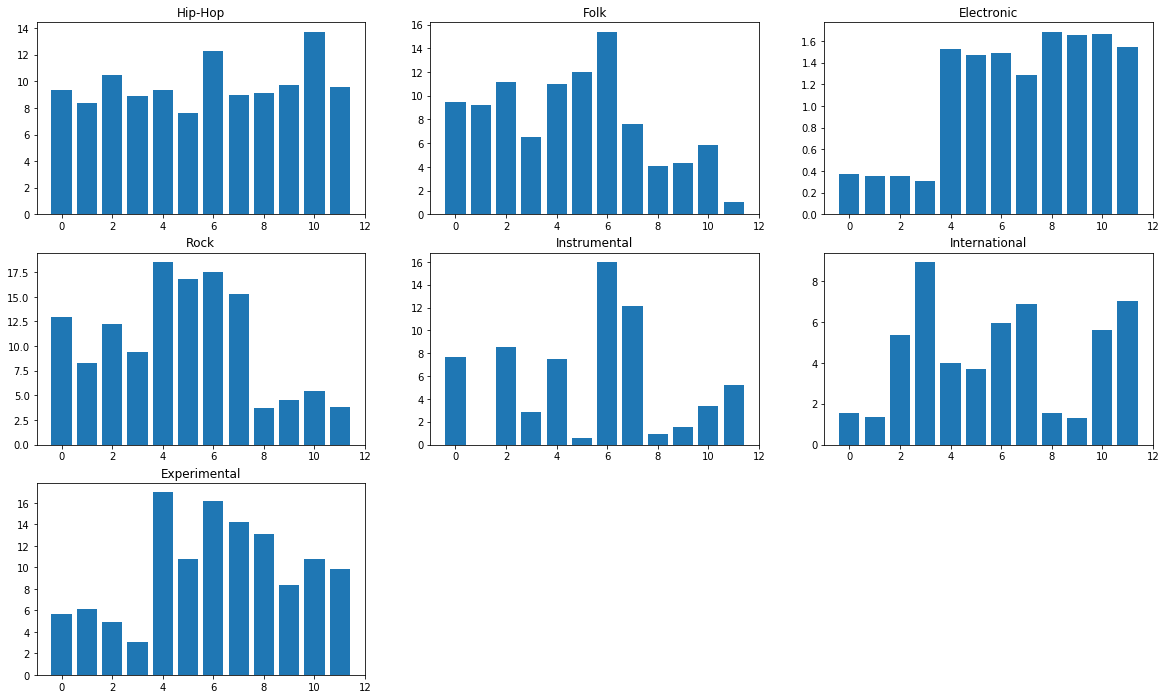

In [67]:
# Visualize encoings for random segment from multiple genres

import matplotlib.pyplot as plt
import pylab
%matplotlib inline
pylab.rcParams['figure.figsize'] = (20, 12)

for i, genre in enumerate([hiphop, folk, electronic, rock, instrumental, international, experimental]):
    # print(genre.shape)
    track_idx = genre.index[np.random.randint(genre.shape[0])]
    # print('Plotting {0} track {1}'.format(genre['track', 'genre_top'][track_idx], track_idx))
    encoding = encodings[track_idx]
    plt.subplot(3, 3, i+1)
    plt.title(genre['track', 'genre_top'][track_idx])
    plt.bar(np.arange(encoding.shape[1]), encoding[0,:])
plt.show()

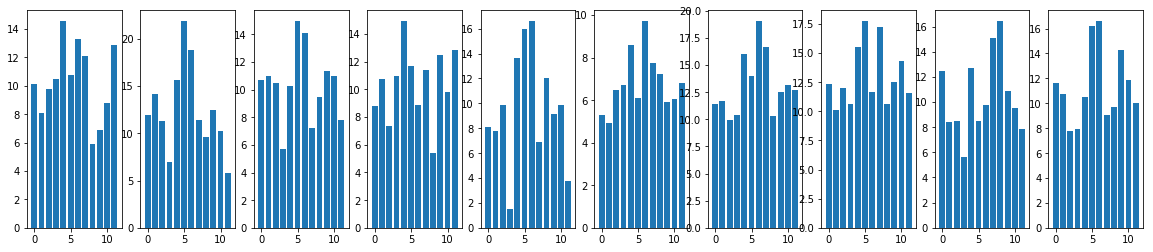

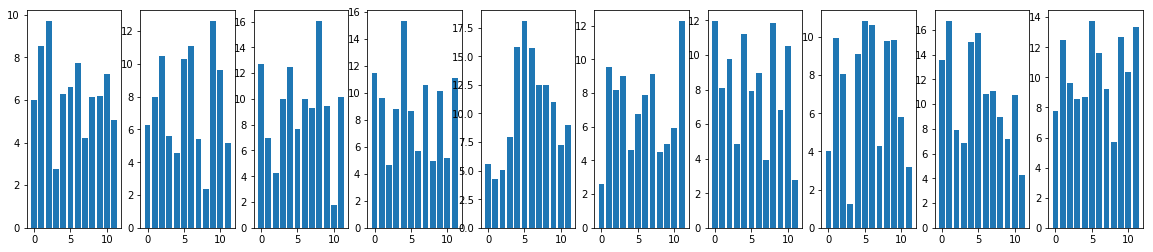

In [68]:
# Visualize the encodings of multiple segmets of the same track

import matplotlib.pyplot as plt
import pylab
%matplotlib inline
pylab.rcParams['figure.figsize'] = (20, 4)

segments_to_visulize = 10

track_idx = folk.index[np.random.randint(folk.shape[0])]
encoding = encodings[track_idx]
for i in range(segments_to_visulize):
    plt.subplot(1, segments_to_visulize, i+1)
    #     plt.title(genre['track', 'genre_top'][track_idx])
    plt.bar(np.arange(encoding.shape[1]), encoding[i,:])
plt.show()
track_idx = electronic.index[np.random.randint(electronic.shape[0])]
encoding = encodings[track_idx]
for i in range(segments_to_visulize):
    plt.subplot(1, segments_to_visulize, i+1)
    #     plt.title(genre['track', 'genre_top'][track_idx])
    plt.bar(np.arange(encoding.shape[1]), encoding[i,:])
plt.show()